# 5561 HW5

## Anton King - king1266

### SIFT Feature Matching

In [1]:
from Stereo_Reconstruction import *

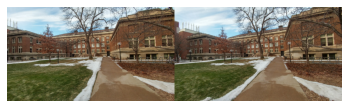

In [2]:
# read in left and right images as RGB images
img_left = cv2.imread('./left.bmp', 1)
img_right = cv2.imread('./right.bmp', 1)
visualize_img_pair(img_left, img_right)

In [3]:
## From HW2
def find_match(img1, img2):

    ## SIFT 
    sift = cv2.xfeatures2d.SIFT_create(edgeThreshold=5,contrastThreshold=0.025)
    kp1,des1 = sift.detectAndCompute(img1,None)
    kp2,des2 = sift.detectAndCompute(img2,None)

    ## Neighbors
    nbrs = NearestNeighbors(n_neighbors=2).fit(des1)
    dists,idxs = nbrs.kneighbors(des2)
    nbrs2 = NearestNeighbors(n_neighbors=2).fit(des2)
    dists2,idxs2 = nbrs2.kneighbors(des1)

    ## Ratio
    x1,x2 = [],[]
    for i,dist in enumerate(dists):
        if dist[0]/dist[1] < 0.7:
            x1.append(kp1[idxs[i][0]].pt)
            x2.append(kp2[i].pt)
    x1_,x2_ = [],[]
    for i,dist in enumerate(dists2):
        if dist[0]/dist[1] < 0.7:
            x1_.append(kp1[i].pt)
            x2_.append(kp2[idxs2[i][0]].pt)
    dists = []
    final_x1,final_x2 = [],[]
    for i,ele in enumerate(x1):
        for j,ele2 in enumerate(x1_):
            if np.linalg.norm(np.array(ele)-np.array(ele2)) < 17:
                if np.linalg.norm(np.array(x2[i])-np.array(x2_[j])) < 17:
                    final_x2.append(x2[i])
                    final_x1.append(ele)
                    
    return np.array(final_x1),np.array(final_x2)

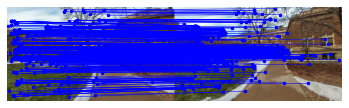

In [4]:
# Step 1: find correspondences between image pair
pts1, pts2 = find_match(img_left, img_right)
visualize_find_match(img_left, img_right, pts1, pts2)

In [5]:
def compute_F(pts1, pts2):
    ransac_iter = 3000
    max_inliers = 0
    F_best = None
    for itr in range(ransac_iter):

        ## 8 random correspondences
        np.random.seed(itr*2+13)
        coords = np.random.randint(len(pts1),size=8)
        A = []
        for i,c in enumerate(coords):
            ux, uy = pts1[c][0], pts1[c][1]
            vx,vy = pts2[c][0],pts2[c][1]
            A.append([ux*vx,uy*vx,vx,ux*vy,uy*vy,vy,ux,uy,1])
        A = np.array(A)

        ## Solve Ax=0 using null space of A
        x = null_space(A)
        if x.shape[1] != 1:
            continue
        x = x.reshape((3,3))

        ## SVD Cleanup
        u,s,v = np.linalg.svd(x)
        s = np.vstack((np.diag(s)[:2],np.array([0,0,0])))
        F = u @ s @ v

        ## Calculate Inliers
        inside = []
        for i in range(len(pts1)):
            v = np.array([pts1[i][0],pts1[i][1],1])
            u = np.array([pts2[i][0],pts2[i][1],1])
            dist = np.sum(np.abs(u * F * v))
            if dist < 17:
                inside.append((v,u))

        if len(inside) > max_inliers:
            max_inliers = len(inside)
            F_best = F
            
    np.save('fundamental_matrix.npy',F)
    
    return F_best

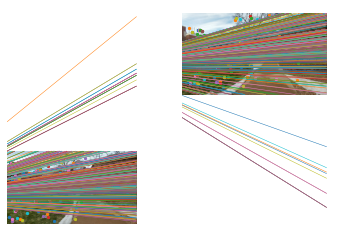

In [6]:
# Step 2: compute fundamental matrix
F = compute_F(pts1, pts2)
visualize_epipolar_lines(F, pts1, pts2, img_left, img_right)

C:\Users\agent\anaconda3\envs\cv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\agent\anaconda3\envs\cv\lib\site-packages\numpy\lib\stride_tricks.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  array = np.array(array, copy=False, subok=subok)
C:\Users\agent\anaconda3\envs\cv\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

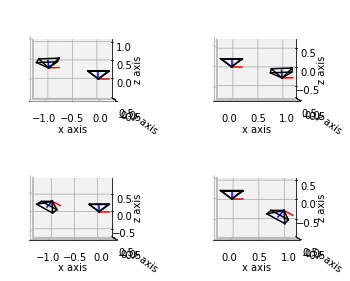

In [8]:
# Step 3: computes four sets of camera poses
K = np.array([[350, 0, 960/2], [0, 350, 540/2], [0, 0, 1]])
Rs, Cs = compute_camera_pose(F, K)
visualize_camera_poses(Rs, Cs)

In [9]:
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((Rs[0], -Rs[0] @ Cs[0]))

In [179]:
pts1.shape

(1001, 2)

In [189]:
u = np.hstack((pts1[0],1)).reshape(3,1)
u

array([[ 10.38219833],
       [485.70126343],
       [  1.        ]])

In [191]:
A_ = u * P1
A_

array([[3.63376942e+03, 0.00000000e+00, 4.98345520e+03, 0.00000000e+00],
       [0.00000000e+00, 1.69995442e+05, 1.31139341e+05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [192]:
_, idxs = sympy.Matrix(A_).T.rref()
idxs

(0, 1, 2)